In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from PIL import Image
import random
import pandas as pd

In [19]:
dataset_path = "/content/drive/MyDrive/DATASET/animal_dataset"
categories = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]
print("Categories found:", categories)

Categories found: ['panda', 'cat', 'dog']


In [20]:
IMG_SIZE = 32
processed_data = []

for label, cat in enumerate(categories):
    folder = os.path.join(dataset_path, cat)

    for img_name in tqdm(os.listdir(folder), desc=f"Loading {cat}"):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        processed_data.append([resized.flatten(), label])

print("Total images loaded:", len(processed_data))

Loading dog: 100%|██████████| 100/100 [00:02<00:00, 46.86it/s]

Total images loaded: 300


In [21]:
random.seed(42)
random.shuffle(processed_data)
fold_size = len(processed_data) // 5
folds = [
    processed_data[0:fold_size],
    processed_data[fold_size:fold_size*2],
    processed_data[fold_size*2:fold_size*3],
    processed_data[fold_size*3:fold_size*4],
    processed_data[fold_size*4:]
]
print("Fold sizes:", [len(f) for f in folds])

Fold sizes: [60, 60, 60, 60, 60]


In [23]:
def calc_l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def calc_l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [24]:
def knn_predict(X_train, y_train, x_test, k=3, metric='L2'):
    distances = []

    for i in range(len(X_train)):
        if metric == 'L1':
            dist = calc_l1_distance(X_train[i], x_test)
        else:
            dist = calc_l2_distance(X_train[i], x_test)

        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])
    top_k = [label for _, label in distances[:k]]

    vote = {}
    for l in top_k:
        vote[l] = vote.get(l, 0) + 1

    return max(vote, key=vote.get)

In [26]:
K_values = list(range(1, 11))
metrics = ['L1', 'L2']

cv_results = {m: [[] for _ in range(5)] for m in metrics}

for metric in metrics:
    print(f"\n==================== {metric} Distance ====================")

    for fold_idx in range(5):
        val = folds[fold_idx]
        train = [item for i, f in enumerate(folds) if i != fold_idx for item in f]

        X_train = np.array([img for img, lab in train])
        y_train = np.array([lab for img, lab in train])
        X_val = np.array([img for img, lab in val])
        y_val = np.array([lab for img, lab in val])

        for k in K_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, metric=metric)
                if pred == y_val[i]:
                    correct += 1

            acc = (correct / len(X_val)) * 100
            cv_results[metric][fold_idx].append(acc)

    print("\nK  |    Fold1       Fold2       Fold3       Fold4       Fold5")
    print("----------------------------------------------------------------")
    for i, k in enumerate(K_values):
        row = f"{k:<2} | "
        for fold_idx in range(5):
            row += f"{cv_results[metric][fold_idx][i]:7.2f}%    "
        print(row)



==================== L1 Distance ====================

K  |    Fold1       Fold2       Fold3       Fold4       Fold5
----------------------------------------------------------------
1  |   41.67%      25.00%      26.67%      38.33%      35.00%    
2  |   41.67%      25.00%      26.67%      38.33%      35.00%    
3  |   30.00%      21.67%      31.67%      40.00%      20.00%    
4  |   33.33%      21.67%      36.67%      38.33%      35.00%    
5  |   25.00%      25.00%      35.00%      36.67%      23.33%    
6  |   28.33%      15.00%      33.33%      35.00%      26.67%    
7  |   26.67%      20.00%      35.00%      38.33%      25.00%    
8  |   33.33%      20.00%      35.00%      33.33%      30.00%    
9  |   31.67%      25.00%      33.33%      40.00%      31.67%    
10 |   35.00%      21.67%      33.33%      36.67%      30.00%    

==================== L2 Distance ====================

K  |    Fold1       Fold2       Fold3       Fold4       Fold5
---------------------------------------

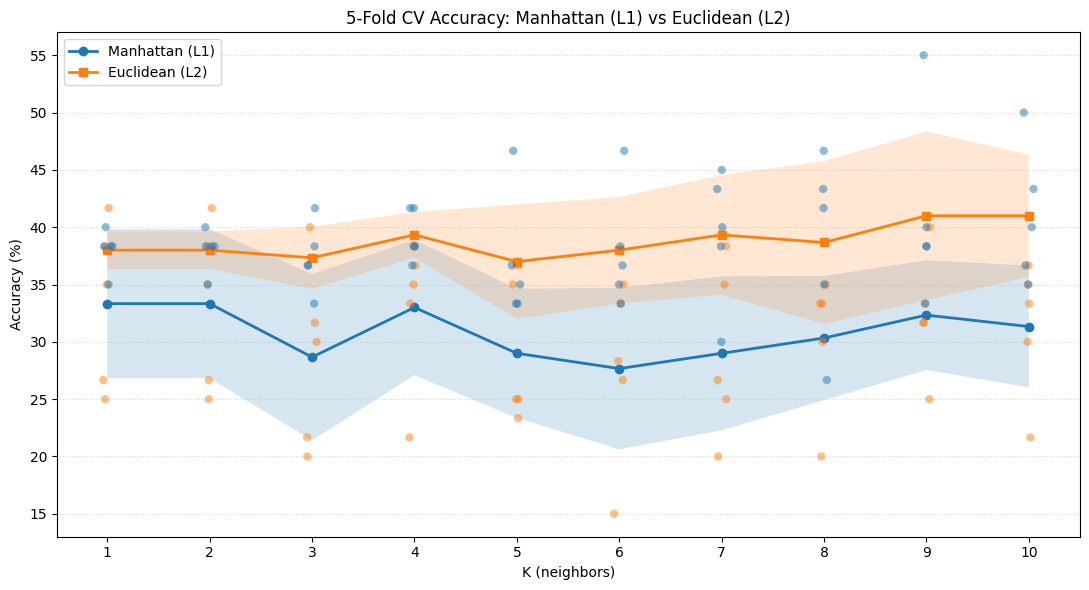

L1 Best K: 1 with Accuracy: 33.33%
L2 Best K: 9 with Accuracy: 41.00%


In [31]:
k_list = K_values
metrics_plot = ['L1','L2']

def stats_for(metric):
    arr = np.array([cv_results[metric][fold_idx] for fold_idx in range(5)])  # shape (folds, K)
    arr = arr.T  # shape (K, folds)
    means = arr.mean(axis=1)
    stds = arr.std(axis=1)
    return arr, means, stds

l1_arr, l1_means, l1_stds = stats_for('L1')
l2_arr, l2_means, l2_stds = stats_for('L2')

plt.figure(figsize=(11,6))

x = np.array(k_list)

plt.plot(x, l1_means, marker='o', linewidth=2, label='Manhattan (L1)', zorder=4)
plt.fill_between(x, l1_means - l1_stds, l1_means + l1_stds, alpha=0.18)

plt.plot(x, l2_means, marker='s', linewidth=2, label='Euclidean (L2)', zorder=4)
plt.fill_between(x, l2_means - l2_stds, l2_means + l2_stds, alpha=0.18)

rng = 0.10
for ki, k in enumerate(k_list):
    jitter = (np.random.rand(l1_arr.shape[1]) - 0.5) * rng
    plt.scatter([k + j for j in jitter], l1_arr[ki], color='tab:orange', alpha=0.5, s=36, edgecolor='none', zorder=5)
    jitter = (np.random.rand(l2_arr.shape[1]) - 0.5) * rng
    plt.scatter([k + j for j in jitter], l2_arr[ki], color='tab:blue', alpha=0.5, s=36, edgecolor='none', zorder=5)

best_l1_k = k_list[int(np.argmax(l1_means))]
best_l2_k = k_list[int(np.argmax(l2_means))]
best_l1_acc = l1_means.max()
best_l2_acc = l2_means.max()

plt.xlabel('K (neighbors)')
plt.ylabel('Accuracy (%)')
plt.title('5-Fold CV Accuracy: Manhattan (L1) vs Euclidean (L2)')
plt.xticks(k_list)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()

out_png = '/content/knn_cv_plot_alt.png'
plt.savefig(out_png, dpi=160)
plt.show()

print(f"L1 Best K: {best_l1_k} with Accuracy: {best_l1_acc:.2f}%")
print(f"L2 Best K: {best_l2_k} with Accuracy: {best_l2_acc:.2f}%")


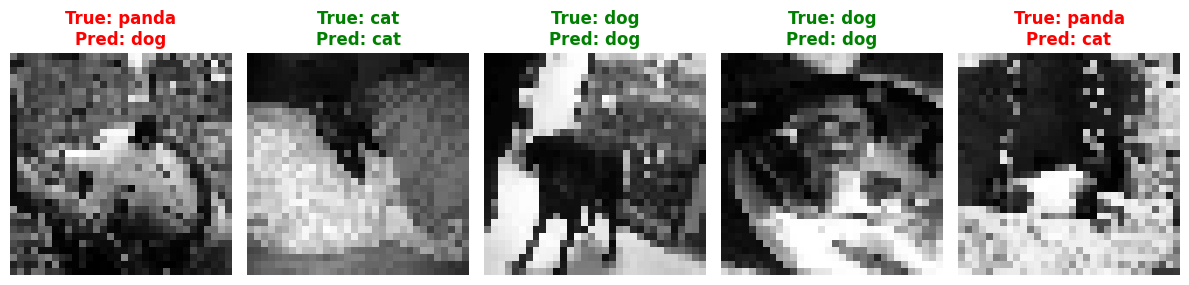

In [38]:
X = np.array([img for img, lbl in processed_data], dtype=np.float32)
y = np.array([lbl for img, lbl in processed_data])

np.random.seed(42)
rand_idx = np.random.choice(len(X), 5, replace=False)

X_demo = X[rand_idx]
y_demo = y[rand_idx]

full_train = [item for f in folds for item in f]
X_full = np.array([img for img, lbl in full_train])
y_full = np.array([lbl for img, lbl in full_train])

k_demo = best_l2_k
metric_demo = 'L2'

preds = []
for i in range(5):
    p = knn_predict(X_full, y_full, X_demo[i], k=k_demo, metric=metric_demo)
    preds.append(p)

preds = np.array(preds)

plt.figure(figsize=(12,4))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_demo[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

    true_label = categories[y_demo[i]]
    pred_label = categories[preds[i]]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color=color, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()


Image Classification: Manhattan (L1) vs. Euclidean (L2) Distance with 5-Fold Cross-Validation
1. Dataset and Preprocessing

The dataset contains 300 images across three classes: panda, cat, and dog.
To prepare the data for classification:

All images were converted to grayscale to reduce complexity.

Images were resized to 32×32 pixels, producing compact 1024-dimensional feature vectors.

The pixel values were flattened to 1D arrays for KNN input.

This preprocessing reduces computation time while preserving important shape and texture features.

2. Model Building and Evaluation

A K-Nearest Neighbors (KNN) classifier was implemented from scratch.
Two distance metrics were used:

Manhattan distance (L1)

Euclidean distance (L2)

To evaluate performance, 5-fold cross-validation was applied.
For each fold, the model was trained on 4 subsets and tested on the remaining one.
K values from 1 to 10 were tested to observe how neighborhood size affects accuracy.

3. Results and Analysis

For each combination of distance metric and K value, accuracy was computed across all 5 folds.

Best L1 accuracy: 33.33% at K = 1

Best L2 accuracy: 41.00% at K = 9

The accuracy graph showed that:

L2 produces smoother and more stable accuracy curves

L1 fluctuates more heavily across folds

Higher K values generally improve stability for L2

This indicates that Euclidean distance is better suited for comparing grayscale pixel vectors in this dataset.

4. Discussion

Overall, Euclidean (L2) outperformed Manhattan (L1) for this task.
L2 likely performs better because it emphasizes larger pixel-intensity differences, which helps separate visually distinct classes in 32×32 grayscale images.

However, the accuracy remains modest because:

The dataset is small (only 300 images)

Raw grayscale pixels are weak features

Important color/texture information is lost during preprocessing

Images are low resolution (32×32)

Potential Improvements

Use RGB images instead of grayscale

Increase image resolution

Apply feature extraction (HOG, LBP, PCA)

Use deep learning (CNNs) for richer feature learning

5. Top 5 Predictions

Five random images were tested using the best L2 model.
Each image was displayed with its true label and predicted label.

Correct predictions were shown in green

Incorrect predictions were shown in red

This visualization demonstrates how the model performs on individual examples, highlighting both strengths and common misclassifications.